<p style="font-family: Arial; font-size:1.75em;color:#003399; font-style:bold"><br>
 Filtracja obrazu 
</p><br>
W tej części porównane będą różne metody przygotowania obrazów do dalszej analizy:
<tr>1. Zminiejszenie rozdzielczości (róznież jako forma usuwania szumów)</tr><br>
<tr>2. Usuwanie szumów filtrem gaussa oraz filtrem medianowym używając tzw. "wędrującego okna"</tr><br>
<tr>3. Usuwanie szumów poprzez tranformacje sygnału - filtr falkowy (wavelet), bilateralny i Chambolle</tr><br>
<tr>4. Wyostrzanie granic obiektów - porównanie filtrów Sobel`a, Prewitt`a i Roberts`a</tr><br>
<tr>5. Ocena zmniejszenia szumów poprzez zastosowanie wybranych charakterystyk opisu obrazów</tr><br>
<tr>6. Tworzenie obrazów binarnych różnymi metodami progrogowania</tr><br>
<tr>7. "Czyszczenie" obrazów binarnych </tr><br>
<tr>8. Scharakteryzowanie tekstury fragmentów obrazu różnego typu metodą GLCM (grey level co-occurrence matrices, GLCM) </tr><br>

In [2]:
import os
import sys
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
from skimage import io, img_as_float, img_as_ubyte, exposure, img_as_int

In [3]:
im = io.imread('S1B_EW_GRDM_1SDH_20180206T050415_Botnicka.tif')

<i>---------Zmniejszenie rozdzielczości przestrzennej obrazu-----------</i>

In [5]:
from skimage import exposure, transform

def contrast_perc(band, d, u):
    lower = np.percentile(band,d)
    upper = np.percentile(band,u)
    rescaled = exposure.rescale_intensity(band,in_range=(lower, upper))
    
    return(rescaled)

# subsampling 10-krotny
n = 10
imS = transform.downscale_local_mean(im,(n,n))


r0 = contrast_perc(im, 1,99)
rS = contrast_perc(imS, 1,99)

fig = plt.figure(figsize=(15,15))
ax0 = plt.subplot(121)
ax0.imshow(r0,cmap=plt.get_cmap('gray'))

# zaznaczenie obszaru, z którym będziemy dalej pracować
aoi = im[4600:5200,3800:4500]
ice = exposure.equalize_hist(aoi)
back = im * 0
back[4600:5200,3800:4500] = 1
cm = colors.ListedColormap(["#FFFFFF00", '#CC000080'])
plt.imshow(back,cmap=cm)

ax0.set_title("Original resolution")
ax1 = plt.subplot(122)
ax1.imshow(rS,cmap=plt.get_cmap('gray'))
ax1.set_title("Subsampled %d times" % (n))
plt.show()

<i>-------Filtracja szumów-------</i>

Poniżej pokazana jest zasada działania filtracji dolnoprzepustowej. Po lewej pokazana jest lokalizacja okna filtracji, a po prawej zmiany wartości otrzymywane w wyniku filtracji średniej.

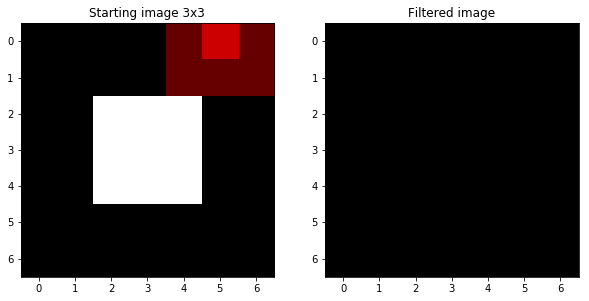

KeyboardInterrupt: 

In [7]:
from IPython.display import clear_output
import time
w77 = np.zeros((7,7))
w77[2:5,2:5] = 1.0

cm = colors.ListedColormap(["#00000000","#EE0000", '#CC000080','#CC0000'])
w77mean = np.zeros_like(w77)
for i in range(0,7):
    for j in range(0,7):
        window = w77[max(0,(i-1)):min(7,(i+1+1)),max(0,(j-1)):min(7,(j+1+1))]
        w77mean[i,j] = np.mean(window)
        w77proc = np.zeros_like(w77)
        w77proc[max(0,(i-1)):min(7,(i+1+1)),max(0,(j-1)):min(7,(j+1+1))] = 1
        w77proc[i,j] = 2
        clear_output()
        fig = plt.figure(figsize=(10, 10))
        ax0 = plt.subplot(121)
        ax0.imshow(w77,cmap=plt.get_cmap('gray'))
        ax0.imshow(w77proc,cmap=cm)
        ax0.set_title("Starting image 3x3")
        ax1 = plt.subplot(122)
        ax1.imshow(w77mean,cmap=plt.get_cmap('gray'))
        ax1.set_title("Filtered image")
        plt.show()
        time.sleep(1)

In [9]:
from skimage.filters import median

## filtr medianowy
w3 = np.ones((3,3)) # wielkość okna
med3 = median(ice,selem=w3)

w5 = np.ones((5,5)) # wielkość okna
med5 = median(ice,selem=w5)

w7 = np.ones((7,7)) # wielkość okna
med7 = median(ice,selem=w7)

fig = plt.figure(figsize=(20, 10))
ax0 = plt.subplot(231)
ax0.imshow(med3,cmap=plt.get_cmap('gray'))
ax0.set_title("Median filter 3x3")
ax1 = plt.subplot(232)
ax1.imshow(med5,cmap=plt.get_cmap('gray'))
ax1.set_title("Median filter 5x5")
ax2 = plt.subplot(233)
ax2.imshow(med7,cmap=plt.get_cmap('gray'))
ax2.set_title("Median filter 7x7")

w33 = np.linspace(1,9,9).reshape(3,3); w3[1,1] = 0
w55 = np.linspace(1,25,25).reshape(5,5);w5[2,2] = 0
w77 = np.linspace(1,49,49).reshape(7,7);w7[3,3] = 0 
cm = colors.ListedColormap(["#CC0000", '#E6E6E600'])

ax3 = plt.subplot(234)
ax3.imshow(w33,cmap=plt.get_cmap('gray'))
ax3.imshow(w3,cmap=cm)
ax3.set_title("Window 3x3")
ax4 = plt.subplot(235)
ax4.imshow(w55,cmap=plt.get_cmap('gray'))
ax4.imshow(w5,cmap=cm)
ax4.set_title("Window 5x5")
ax5 = plt.subplot(236)
ax5.imshow(w77,cmap=plt.get_cmap('gray'))
ax5.imshow(w7,cmap=cm)
ax5.set_title("Window 7x7")

fig.tight_layout()
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\skimage\util\dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


In [14]:
from skimage.filters import gaussian


## filtr gaussa
g1 = gaussian(ice, sigma=1.5, preserve_range=True)
g2 = gaussian(ice, sigma=3, preserve_range=True)

fig = plt.figure(figsize=(20, 30))
ax0 = plt.subplot(131)
ax0.imshow(ice,cmap=plt.get_cmap('gray'))
ax0.set_title("Original file")
ax1 = plt.subplot(132)
ax1.imshow(g1,cmap=plt.get_cmap('gray'))
ax1.set_title("Gaussian filter sigma = 1.5")
ax2 = plt.subplot(133)
ax2.imshow(g2,cmap=plt.get_cmap('gray'))
ax2.set_title("Gaussian filter sigma = 3")

fig.tight_layout()
plt.show()

In [15]:
from skimage.restoration import denoise_tv_chambolle, denoise_bilateral, denoise_wavelet

## filtr 
chambolle_a = denoise_tv_chambolle(ice, weight=0.1, multichannel=False)
bilat_a = denoise_bilateral(ice, sigma_color=0.05, sigma_spatial=15,multichannel=False)
wavelet = denoise_wavelet(ice, multichannel=False)
chambolle_b = denoise_tv_chambolle(ice, weight=0.5, multichannel=False)
bilat_b = denoise_bilateral(ice, sigma_color=0.1, sigma_spatial=30,multichannel=False)


fig = plt.figure(figsize=(20, 10))
ax0 = plt.subplot(231)
ax0.imshow(ice,cmap=plt.get_cmap('gray'))
ax0.set_title("Original file")
ax1 = plt.subplot(232)
ax1.imshow(chambolle_a,cmap=plt.get_cmap('gray'))
ax1.set_title("TV Chambolle filter (a)")
ax2 = plt.subplot(233)
ax2.imshow(bilat_a,cmap=plt.get_cmap('gray'))
ax2.set_title("Bilateral filter (a)")

ax3 = plt.subplot(234)
ax3.imshow(wavelet,cmap=plt.get_cmap('gray'))
ax3.set_title("Wavelet filter")
ax4 = plt.subplot(235)
ax4.imshow(chambolle_b,cmap=plt.get_cmap('gray'))
ax4.set_title("TV Chambolle filter (b)")
ax5 = plt.subplot(236)
ax5.imshow(bilat_b,cmap=plt.get_cmap('gray'))
ax5.set_title("Bilateral filter (b)")

fig.tight_layout()
plt.show()

<i>-------Śledzenie zmiany sygnału na przekroju-------</i>

In [19]:
from matplotlib import colors

org = ice[300,:]
bilateral = bilat_a[300,:]
wave = wavelet[300,:]
chambolle = chambolle_a[300,:]

cm = colors.ListedColormap(['#E6E6E600',"#CC0000"])
line = np.zeros_like(ice)
line[300,:] = 1

fig = plt.figure(figsize=(20, 10))
ax0 = plt.subplot(121)
ax0.imshow(ice,cmap=plt.get_cmap('gray'))
ax0.imshow(line,cmap=cm)
ax0.set_title("Profile location")
ax1 = plt.subplot(122)
ax1.plot(org,color='black')
ax1.plot(wave,color='green')
ax1.plot(bilateral,color='blue')
ax1.plot(chambolle,color='red')
ax1.set_title("Intersect")

plt.show()

<i>-------Miary używane do porównywania obrazów-------</i>

In [22]:
from skimage.measure import compare_ssim, compare_psnr

def MSE(A, B):
     return(np.square(A - B).mean())


    #Oblicz SSIM (Structural Similarity Index)
ssim_bilat_a = compare_ssim(ice,bilat_a,win_size=7,multichannel=False)
ssim_chambolle_a = compare_ssim(ice,chambolle_a,win_size=7,multichannel=False)
ssim_wavelet = compare_ssim(ice,wavelet,win_size=7,multichannel=False)
ssim_bilat_b = compare_ssim(ice,bilat_b,win_size=7,multichannel=False)
ssim_chambolle_b = compare_ssim(ice,chambolle_b,win_size=7,multichannel=False)

# Oblicz MSE (Mean Square Error)
MSE_bilat_a = MSE(ice,bilat_a)
MSE_chambolle_a = MSE(ice,chambolle_a)
MSE_wavelet = MSE(ice,wavelet)
MSE_bilat_b = MSE(ice,bilat_b)
MSE_chambolle_b = MSE(ice,chambolle_b)

# Oblicz PSNR (Peak Signal to Noise Ratio)
psnr_bilat_a = compare_psnr(ice,bilat_a)
psnr_chambolle_a = compare_psnr(ice,chambolle_a)
psnr_wavelet = compare_psnr(ice,wavelet)
psnr_bilat_b = compare_psnr(ice,bilat_b)
psnr_chambolle_b = compare_psnr(ice,chambolle_b)

print("TV Chambolle filter (a):\t\tMSE: %.3f, SSIM: %.3f, PSNR: %.3f" % 
      (MSE_chambolle_a,ssim_chambolle_a,psnr_chambolle_a))
print("Bilateral filter (a):\t\t\tMSE: %.3f, SSIM: %.3f, PSNR: %.3f" % 
      (MSE_bilat_a,ssim_bilat_a,psnr_bilat_a))
print("Wavelet filter:\t\t\t\tMSE: %.3f, SSIM: %.3f, PSNR: %.3f" % 
      (MSE_wavelet,ssim_wavelet,psnr_wavelet))
print("TV Chambolle filter (b):\t\tMSE: %.3f, SSIM: %.3f, PSNR: %.3f" % 
      (MSE_chambolle_b,ssim_chambolle_b,psnr_chambolle_b))
print("Bilateral filter (b):\t\t\tMSE: %.3f, SSIM: %.3f, PSNR: %.3f" % 
      (MSE_bilat_b,ssim_bilat_b,psnr_bilat_b))

<i>-------Wydobywanie granic obiektów-------</i>

In [24]:
from skimage.filters import sobel, prewitt, roberts

# okno poglądowe
w = np.zeros((7,7)) 
w[3,3] = 1

## filtr Sobela
wS = sobel(w)
iceS = sobel(ice)

# filtr Prewitta
wP = prewitt(w)
iceP = prewitt(ice)

#filt Robertsa
wR = roberts(w)
iceR = roberts(ice)

fig = plt.figure(figsize=(20, 10))
ax0 = plt.subplot(331)
ax0.imshow(wS,cmap=plt.get_cmap('gray'))
ax0.set_title("Sobel filter")
ax1 = plt.subplot(332)
ax1.imshow(wP,cmap=plt.get_cmap('gray'))
ax1.set_title("Prewitt filter")
ax2 = plt.subplot(333)
ax2.imshow(wR,cmap=plt.get_cmap('gray'))
ax2.set_title("Roberts filter")

ax3 = plt.subplot(334)
ax3.imshow(iceS,cmap=plt.get_cmap('gray'))
ax3.set_title("Sobel filter")
ax4 = plt.subplot(335)
ax4.imshow(iceP,cmap=plt.get_cmap('gray'))
ax4.set_title("Prewitt filter")
ax5 = plt.subplot(336)
ax5.imshow(iceR,cmap=plt.get_cmap('gray'))
ax5.set_title("Roberts filter")

ax6 = plt.subplot(337)
ax6.imshow(iceS[400:600,300:500],cmap=plt.get_cmap('gray'))
ax6.set_title("Sobel filter")
ax7 = plt.subplot(338)
ax7.imshow(iceP[400:600,300:500],cmap=plt.get_cmap('gray'))
ax7.set_title("Prewitt filter")
ax8 = plt.subplot(339)
ax8.imshow(iceR[400:600,300:500],cmap=plt.get_cmap('gray'))
ax8.set_title("Roberts filter")


fig.tight_layout()
plt.show()

In [26]:
from skimage.filters import median, sobel, prewitt, roberts

# wstępna filtracja
w = np.ones((7,7)) 
M = median(ice,selem=w)

## filtr Sobela
iceS = sobel(ice)
iceMS = sobel(M)

# filtr Prewitta
iceP = prewitt(ice)
iceMP = prewitt(M)

#filt Robertsa
iceR = roberts(ice)
iceMR = roberts(M)

fig = plt.figure(figsize=(20, 10))
ax0 = plt.subplot(331)
ax0.imshow(iceS,cmap=plt.get_cmap('gray'))
ax0.set_title("Sobel filter")
ax1 = plt.subplot(332)
ax1.imshow(iceP,cmap=plt.get_cmap('gray'))
ax1.set_title("Prewitt filter")
ax2 = plt.subplot(333)
ax2.imshow(iceR,cmap=plt.get_cmap('gray'))
ax2.set_title("Roberts filter")

ax3 = plt.subplot(334)
ax3.imshow(iceS[400:600,300:500],cmap=plt.get_cmap('gray'))
ax3.set_title("Sobel filter")
ax4 = plt.subplot(335)
ax4.imshow(iceP[400:600,300:500],cmap=plt.get_cmap('gray'))
ax4.set_title("Prewitt filter")
ax5 = plt.subplot(336)
ax5.imshow(iceR[400:600,300:500],cmap=plt.get_cmap('gray'))
ax5.set_title("Roberts filter")

ax6 = plt.subplot(337)
ax6.imshow(iceMS[400:600,300:500],cmap=plt.get_cmap('gray'))
ax6.set_title("Sobel filter")
ax7 = plt.subplot(338)
ax7.imshow(iceMP[400:600,300:500],cmap=plt.get_cmap('gray'))
ax7.set_title("Prewitt filter")
ax8 = plt.subplot(339)
ax8.imshow(iceMR[400:600,300:500],cmap=plt.get_cmap('gray'))
ax8.set_title("Roberts filter")


fig.tight_layout()
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\skimage\util\dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


In [28]:
from skimage.filters import median, sobel_h, sobel_v, prewitt_h, prewitt_v, roberts_pos_diag, roberts_neg_diag

# przybliżenie i wstępna filtracja
zoom = ice[400:600,300:500]
w = np.ones((5,5)) 
M = median(zoom,selem=w)

test = np.zeros((7,7))
test[3,3] = 1

## filtr Sobela
iceS = sobel_h(test)
icehS = sobel_h(M)
icevS = sobel_v(M)

# filtr Prewitta
iceP = prewitt_h(test)
icehP = prewitt_h(M)
icevP = prewitt_v(M)

#filt Robertsa
iceR = roberts_neg_diag(test)
icepR = roberts_pos_diag(M)
icenR = roberts_neg_diag(M)

fig = plt.figure(figsize=(20, 10))
ax0 = plt.subplot(331)
ax0.imshow(iceS,cmap=plt.get_cmap('gray'))
ax0.set_title("Sobel filter - horizontal")
ax1 = plt.subplot(332)
ax1.imshow(iceP,cmap=plt.get_cmap('gray'))
ax1.set_title("Prewitt filter - horizontal")
ax2 = plt.subplot(333)
ax2.imshow(iceR,cmap=plt.get_cmap('gray'))
ax2.set_title("Roberts filter - negative diag")

ax3 = plt.subplot(334)
ax3.imshow(icehS,cmap=plt.get_cmap('gray'))
ax3.set_title("Sobel filter - horizontal")
ax4 = plt.subplot(335)
ax4.imshow(icehP,cmap=plt.get_cmap('gray'))
ax4.set_title("Prewitt filter - horizontal")
ax5 = plt.subplot(336)
ax5.imshow(icepR,cmap=plt.get_cmap('gray'))
ax5.set_title("Roberts filter - positive")

ax6 = plt.subplot(337)
ax6.imshow(icevS,cmap=plt.get_cmap('gray'))
ax6.set_title("Sobel filter - vertical")
ax7 = plt.subplot(338)
ax7.imshow(icevP,cmap=plt.get_cmap('gray'))
ax7.set_title("Prewitt filter- vertical")
ax8 = plt.subplot(339)
ax8.imshow(icenR,cmap=plt.get_cmap('gray'))
ax8.set_title("Roberts filter - negative")


fig.tight_layout()
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\skimage\util\dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


<i>-------Tworzenie map binarnych-------</i>

In [29]:
from skimage.filters import try_all_threshold

ice = exposure.equalize_hist(aoi)
fig, ax = try_all_threshold(ice, figsize=(20, 20), verbose=False)
plt.show()

<i>-------"Czyszczenie" map binarnych-------</i>

In [33]:
from matplotlib import colors
from skimage import exposure
from skimage.filters import threshold_triangle
from skimage.morphology import binary_opening, binary_closing, remove_small_objects ,remove_small_holes

dich = np.zeros((ice.shape[0],ice.shape[1]))
d = np.zeros((ice.shape[0],ice.shape[1])) + ice
T = threshold_triangle(ice)
print("Thershlod value: %.5f" % T)
dich[d < T] = 1
dich[d >= T] = 0

zoom = img_as_int(dich[100:200,100:200])
d = d * 0
d[100:200,100:200] = 1
cm = colors.ListedColormap(["#CC000000", "#CC000080"])

binaryO = binary_opening(zoom)
binaryC = binary_closing(zoom)
smObj = remove_small_objects(zoom,in_place=False,min_size=64,connectivity=2)
smHoles = remove_small_holes(zoom,in_place=False,min_size=64,connectivity=2)

fig = plt.figure(figsize=(20, 10))
ax0 = plt.subplot(231)
ax0.imshow(dich,cmap=plt.get_cmap('gray'))
ax0.imshow(d,cmap=cm)
ax0.set_title("Black & white mask")
ax1 = plt.subplot(232)
ax1.imshow(binaryO,cmap=plt.get_cmap('gray'))
ax1.set_title("Binary opening filter")
ax2 = plt.subplot(233)
ax2.imshow(binaryC,cmap=plt.get_cmap('gray'))
ax2.set_title("Binary closing filter")

ax3 = plt.subplot(234)
ax3.imshow(zoom,cmap=plt.get_cmap('gray'))
ax3.set_title("Black & white zoom")
ax4 = plt.subplot(235)
ax4.imshow(smObj,cmap=plt.get_cmap('gray'))
ax4.set_title("Removed objects (64)")
ax5 = plt.subplot(236)
ax5.imshow(smHoles,cmap=plt.get_cmap('gray'))
ax5.set_title("Removed holes (64)")

plt.show()

Thershlod value: 0.29102


C:\ProgramData\Anaconda3\lib\site-packages\skimage\util\dtype.py:141: UserWarning: Possible precision loss when converting from float64 to int16
  .format(dtypeobj_in, dtypeobj_out))
C:\ProgramData\Anaconda3\lib\site-packages\skimage\morphology\misc.py:203: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?
  "Did you mean to use a boolean array?", UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\morphology\misc.py:207: UserWarning: the min_size argument is deprecated and will be removed in 0.16. Use area_threshold instead.
  "0.16. Use area_threshold instead.")


<i>-------Opis tekstury obrazu-------</i>

In [35]:
# Wczytanie fragmentu obrazu 
img = im[7600:8600,3500:4500]
up = np.percentile(img,98)
down = np.percentile(img,5)
s = exposure.rescale_intensity(img,in_range=(down,up)) # przeskalowanie wartości
plt.imshow(s,cmap=plt.get_cmap('gray'))
plt.show()

In [37]:
from matplotlib import colors
from skimage import img_as_ubyte

small = img_as_ubyte(s)
source =  small * 0
legend = []
ice_areas = []
dark_ice_areas = []
land_areas = []

# Zdefiniuj wzorcowe obszary dla każdej klasy
# Lód
ice_ul = [(180, 400), (100, 500), (50, 700)]
for ul in ice_ul:
    ice_areas.append(small[ul[0]:(ul[0]+25),
                           ul[1]:(ul[1]+25)])
    source[ul[0]:(ul[0]+25),ul[1]:(ul[1]+25)] = 1                      
    legend.append(1)
# Ciemne pola cienkiego lodu
dark_ice_ul = [(400, 200), (300, 800), (650, 800)]
for ul in dark_ice_ul:
    dark_ice_areas.append(small[ul[0]:(ul[0]+25),
                           ul[1]:(ul[1]+25)])
    source[ul[0]:(ul[0]+25),ul[1]:(ul[1]+25)] = 2
    legend.append(2)
# Ląd
land_ul = [(350, 450), (650, 300), (700, 100)]
for ul in land_ul:
    land_areas.append(small[ul[0]:(ul[0]+25),
                           ul[1]:(ul[1]+25)])
    source[ul[0]:(ul[0]+25),ul[1]:(ul[1]+25)] = 3
    legend.append(3)
    
cm = colors.ListedColormap(["#FFFFFF00", '#5EC9BE','#2CE618','#E69B18'])
plt.imshow(small,cmap=plt.get_cmap('gray'))
plt.imshow(source,cmap=cm)
plt.show()    

C:\ProgramData\Anaconda3\lib\site-packages\skimage\util\dtype.py:137: UserWarning: Possible sign loss when converting negative image of type int32 to positive image of type uint8.
  .format(dtypeobj_in, dtypeobj_out))
C:\ProgramData\Anaconda3\lib\site-packages\skimage\util\dtype.py:141: UserWarning: Possible precision loss when converting from int32 to uint8
  .format(dtypeobj_in, dtypeobj_out))


In [39]:
from skimage.feature import greycomatrix, greycoprops

# Wyznacz charakterystyki dla każdej z grup
diss = []
homog = []
contrast = []
energy = []
corr = []
for area in (ice_areas + dark_ice_areas + land_areas):
    glcm = greycomatrix(area, [10], [5], 256, symmetric=False, normed=True)
    diss.append(greycoprops(glcm, 'dissimilarity')[0, 0])
    homog.append(greycoprops(glcm, 'homogeneity')[0, 0])
    contrast.append(greycoprops(glcm, 'contrast')[0, 0])
    energy.append(greycoprops(glcm, 'energy')[0, 0])
    corr.append(greycoprops(glcm, 'correlation')[0, 0])

# Parametry GLCM: ‘contrast’, ‘dissimilarity’, ‘homogeneity’, ‘energy’, ‘correlation’

# Narysuj wybrane zależności
cm = colors.ListedColormap(['#5EC9BE','#2CE618','#E69B18'])
fig = plt.figure(figsize=(30,5))
ax0 = plt.subplot(131)
ax0.scatter(diss, corr, c=legend, cmap=cm)
ax0.set_xlabel("Dissimilarity",fontsize=25)
ax0.set_ylabel("Correlation",fontsize=25)
ax1 = plt.subplot(132)
ax1.scatter(contrast, energy, c=legend, cmap=cm)
ax1.set_xlabel("Contrast",fontsize=25)
ax1.set_ylabel("Energy",fontsize=25)
ax2 = plt.subplot(133)
ax2.scatter(diss, homog, c=legend, cmap=cm)
ax2.set_xlabel("Dissimilarity",fontsize=25)
ax2.set_ylabel("Homogeneity",fontsize=25)

plt.show()

<i>-------Opis tekstury obrazu kolorowego-------</i>

In [40]:
img = io.imread('S2A_MSIL1C_20190108T095401_N0207_R079_Gozo.tif')
gmg = io.imread('S2A_MSIL1C_20190108T095401_N0207_R079_Gozo.tif', as_grey=True)

red = img[:,:,2]
green = img[:,:,1]
blue = img[:,:,0]

C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:49: UserWarning: `as_grey` has been deprecated in favor of `as_gray`
  warn('`as_grey` has been deprecated in favor of `as_gray`')


In [42]:
from skimage import exposure
from skimage import img_as_ubyte, img_as_float, img_as_int

def contrast_perc(band, d, u):
    lower = np.percentile(band,d)
    upper = np.percentile(band,u)
    rescaled = exposure.rescale_intensity(band,in_range=(lower, upper))
    
    return(rescaled)

# Zmień kontrast 
# pomiędzy percentylami
pU = 98; pD = 7
perc_red = contrast_perc(red, pD, pU)
perc_green = contrast_perc(green, pD, pU)
perc_blue = contrast_perc(blue, pD, pU)
perc = img_as_float(np.stack([perc_red, perc_green, perc_blue], axis=2))

foto = img_as_ubyte(contrast_perc(gmg, 1, 98))

fig = plt.figure(figsize=(10,10))
ax0 = plt.subplot(121)
ax0.imshow(perc)
ax0.set_title("RGB image")
ax1 = plt.subplot(122)
ax1.imshow(foto,cmap=plt.get_cmap('gray'))
ax1.set_title("Grayscale image")

plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\skimage\util\dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


In [44]:
from matplotlib import colors
from skimage import img_as_ubyte, img_as_float, img_as_int

delta = 20

source =  np.zeros_like(foto)
legend = []
sea_areas = []
forest_areas = []
grass_areas = []
urban_areas = []

# Zdefiniuj wzorcowe obszary dla każdej klasy
# Morze
sea_ul = [(0, 0), (0, 500), (50, 500)]
for ul in sea_ul:
    sea_areas.append(foto[ul[0]:(ul[0]+delta),
                           ul[1]:(ul[1]+delta)])
    source[ul[0]:(ul[0]+delta),ul[1]:(ul[1]+delta)] = 1                      
    legend.append(1)
# Las
forest_ul = [(75,75), (125,125), (300,450),(225,50)]
for ul in forest_ul:
    forest_areas.append(foto[ul[0]:(ul[0]+delta),
                           ul[1]:(ul[1]+delta)])
    source[ul[0]:(ul[0]+delta),ul[1]:(ul[1]+delta)] = 2
    legend.append(2)
# Trawy / Łąki
grass_ul = [(250, 130), (210,270), (220,400)]
for ul in grass_ul:
    grass_areas.append(foto[ul[0]:(ul[0]+delta),
                           ul[1]:(ul[1]+delta)])
    source[ul[0]:(ul[0]+delta),ul[1]:(ul[1]+delta)] = 3
    legend.append(3)
    
# Zabudowania
urban_ul = [(100,370), (350,450), (175,165)]
for ul in urban_ul:
    urban_areas.append(foto[ul[0]:(ul[0]+delta),
                           ul[1]:(ul[1]+delta)])
    source[ul[0]:(ul[0]+delta),ul[1]:(ul[1]+delta)] = 4
    legend.append(4)

cm = colors.ListedColormap(["#FFFFFF00", '#5EC9BE','#2CE618','#E69B18','#CC0000'])
plt.imshow(foto,cmap=plt.get_cmap('gray'))
plt.imshow(source,cmap=cm)
plt.show()

In [46]:
from skimage.feature import greycomatrix, greycoprops
    
# compute some GLCM properties each patch
diss = []
homog = []
contrast = []
energy = []
corr = []
for area in (sea_areas + forest_areas + grass_areas + urban_areas):
#    glcm = greycomatrix(area, [5], [0], 256, symmetric=True, normed=True)
    glcm = greycomatrix(area, [10], [5], 256, symmetric=False, normed=True)
    diss.append(greycoprops(glcm, 'dissimilarity')[0, 0])
    homog.append(greycoprops(glcm, 'homogeneity')[0, 0])
    contrast.append(greycoprops(glcm, 'contrast')[0, 0])
    energy.append(greycoprops(glcm, 'energy')[0, 0])
    corr.append(greycoprops(glcm, 'correlation')[0, 0])

# GLCM properties ‘contrast’, ‘dissimilarity’, ‘homogeneity’, ‘energy’, ‘correlation’, ‘ASM’

# Narysuj wybrane zależności
cm = colors.ListedColormap(['#5EC9BE','#2CE618','#E69B18','#CC0000'])

fig = plt.figure(figsize=(30,5))
ax0 = plt.subplot(131)
ax0.scatter(diss, corr, c=legend, cmap=cm)
ax0.set_xlabel("Dissimilarity",fontsize=25)
ax0.set_ylabel("Correlation",fontsize=25)
ax1 = plt.subplot(132)
ax1.scatter(contrast, energy, c=legend, cmap=cm)
ax1.set_xlabel("Contrast",fontsize=25)
ax1.set_ylabel("Energy",fontsize=25)
ax2 = plt.subplot(133)
ax2.scatter(diss, homog, c=legend, cmap=cm)
ax2.set_xlabel("Dissimilarity",fontsize=25)
ax2.set_ylabel("Homogeneity",fontsize=25)

plt.show()